In [64]:
import json
import pandas as pd
import numpy as np
import re
import nltk
import gensim
import spacy
import random
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from gensim import corpora
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from gensim import models
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

In [66]:
# Set the percentage of data to sample
percent_sample = 1

# Open the JSON file and read the data in chunks
json_reader = pd.read_json('amazon/Home_and_Kitchen.json', lines=True, chunksize=10000)

# Create an empty list to store the sampled chunks
sampled_chunks = []

# Loop through the chunks and randomly select a subset
for chunk in json_reader:
    # Calculate the number of rows to sample
    num_rows = int(len(chunk) * percent_sample / 100)
    
    # Randomly select the rows
    random_indices = random.sample(range(len(chunk)), num_rows)
    
    # Append the sampled rows to the list
    sampled_chunks.append(chunk.iloc[random_indices])
    
# Concatenate the sampled chunks into a single dataframe
df = pd.concat(sampled_chunks, ignore_index=True)

In [68]:
print(df.shape[0])

219285


In [70]:
df

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,1,NaN,True,"08 25, 2014",A2B9H1U6B5NDO,B00002N5Z9,andriawilliams,not good,One Star,1408924800,"{'Size:': ' Window Fan', 'Package Quantity:': ' 1'}",NaN
1,5,NaN,True,"01 30, 2015",A3Q8IS2TYTKLHX,B00002N5H5,Greengirl711,Works fine in my bathroom under my cabinets.,Nice light!,1422576000,NaN,NaN
2,2,3.0,True,"05 25, 2017",AFNZR9HSQU2IN,B00002N602,Boomeriscute,"I really was excited to get a stainless steel pressure cooker. However, the stainless steel has been the only good part about this item. I purchased it in December and have struggled to open and ...",the stainless steel has been the only good part about this item,1495670400,{'Size:': ' 4 qt'},NaN
3,5,NaN,True,"04 9, 2018",A2FUUNZF6WFGGX,B00002N602,William N. Recinos C.,"Works very nice, great price..",Five Stars,1523232000,{'Size:': ' 6 qt'},NaN
4,5,NaN,True,"05 9, 2014",A1OVMB2LJCZ1KJ,1935305441,C. Atwood,I really like this little box of every dirty word you could think of. My wife and I work opposite shifts and we leave dirty little messages for each other on the fridge. I would recommend adding...,Little Box of SMUT (for real!),1399593600,{'Color:': ' Smut'},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
219280,5,NaN,True,"07 29, 2018",A1N7492S38DA7C,B01HI1EXY2,Amazon Customer,"Great product at great price! I got these for the summer especially when the AC is on. They are not thick, but enough for what I was looking for. I also like the fabric and the color.",Great product at great price,1532822400,"{'Size:': ' Twin', 'Color:': ' Blue'}",NaN
219281,5,NaN,True,"12 12, 2017",A1DU3GKPLOESFB,B01HGX01AM,Suzanne Cosmo,"Oh yes, it is the perfect size when you are having 3 or more for tea. But the problem is it is too hot to handle, I mean the handle gets so hot one cannot pour without running for a hot pad, I jus...","Brown Betty, Best teapot in the world.",1513036800,NaN,NaN
219282,5,NaN,True,"08 18, 2018",A3VM6IUIP2G3K5,B01HH48VYS,DKOWEN,"We searched everywhere to find a color match to complete our living room set. This fits the bill perfectly! Our order was delivered in less than a week, and set up was a breeze.\nCustomer service ...",Customer service at Rec Pro is awesome. Happy with our purchase,1534550400,{'Color:': ' Toffee'},NaN
219283,5,NaN,True,"12 9, 2017",A7A7CDNDR2NDX,B01HIC1YM0,Simone C. Duven,"Silky soft feel with substantial weight. Beautiful and sturdy pillowcases, highly recommend!",Excellent product and great price!,1512777600,"{'Size:': ' King', 'Color:': ' White'}",NaN


In [71]:
df.describe()

,overall,unixReviewTime
count,219285.000000,2.192850e+05
mean,4.193629,1.449512e+09
std,1.307336,6.176560e+07
min,1.000000,9.480672e+08
25%,4.000000,1.420502e+09
50%,5.000000,1.460765e+09
75%,5.000000,1.491782e+09
max,5.000000,1.538525e+09


In [72]:
df['reviewText'].describe()

count      219141
unique     205874
top       Love it
freq          347
Name: reviewText, dtype: object

In [73]:
df['reviewText'] = df['reviewText'].astype(str)

## Data Preprocessing

In this step, we will remove the punctuations, stopwords and normalize the reviews as much as possible. After every preprocessing step, it is a good practice to check the most frequent words in the data. Therefore, let’s define a function that would plot a bar graph of n most frequent words in the data.

In [74]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

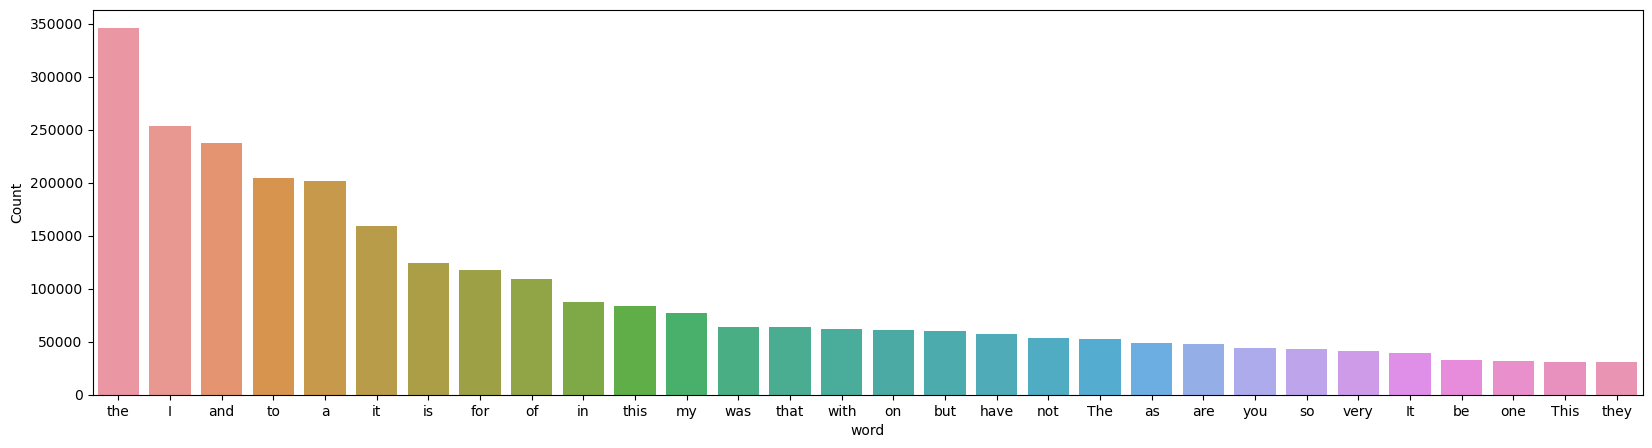

In [75]:
freq_words(df['reviewText'])

Most common words are ‘the’, ‘I’, ‘and’, so on and so forth. These words are not so important for our task and they do not tell any story. We’ have to get rid of these kinds of words. Before that let’s remove the punctuations and numbers from our text data.

In [76]:
# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

/var/folders/br/3ttvc7vj4qgbcjg4chz1k0tr0000gn/T/ipykernel_80567/2763960549.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")


Let’s try to remove the stopwords and short words (<2 letters) from the reviews

In [77]:
stop_words = stopwords.words('english')

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

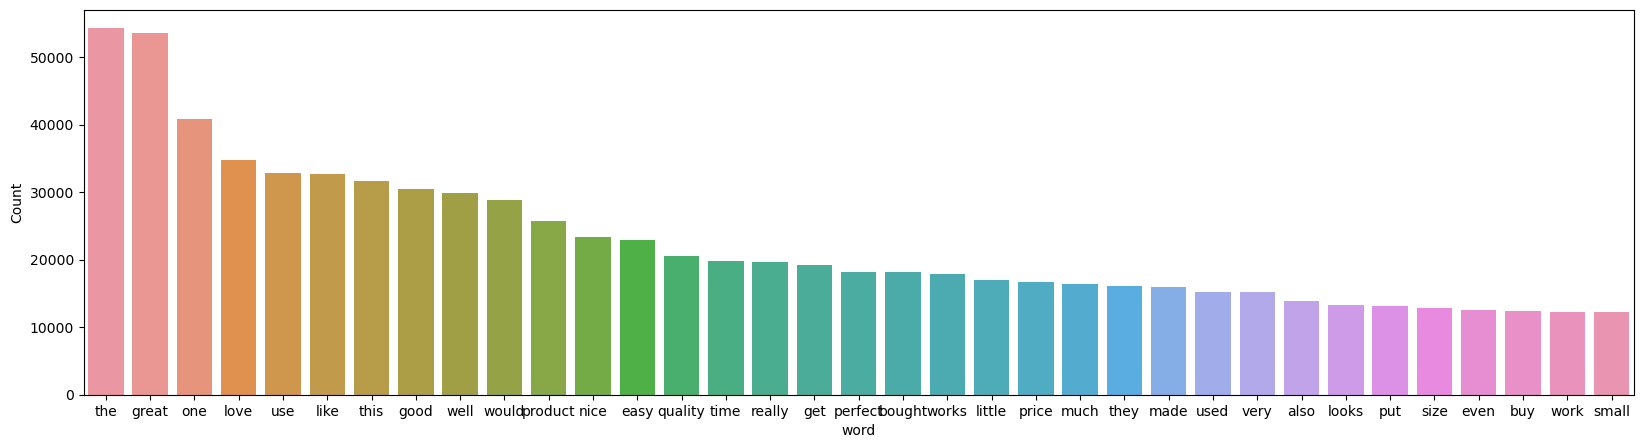

In [78]:
freq_words(reviews, 35)

We can see some improvement here. Terms like ‘quality’, ‘price’, ‘product’, ‘size’ have come up which are quite relevant for the reviwes in this category. However, we still have neutral terms like ‘the’, ‘this’, ‘they’ which are not that relevant.

To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [79]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [80]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['works', 'fine', 'bathroom', 'cabinets']


In [100]:
reviews_2 = lemmatization(tokenized_reviews)

In [99]:
print(reviews_2[1]) # print lemmatized review

['fine', 'bathroom', 'cabinet']


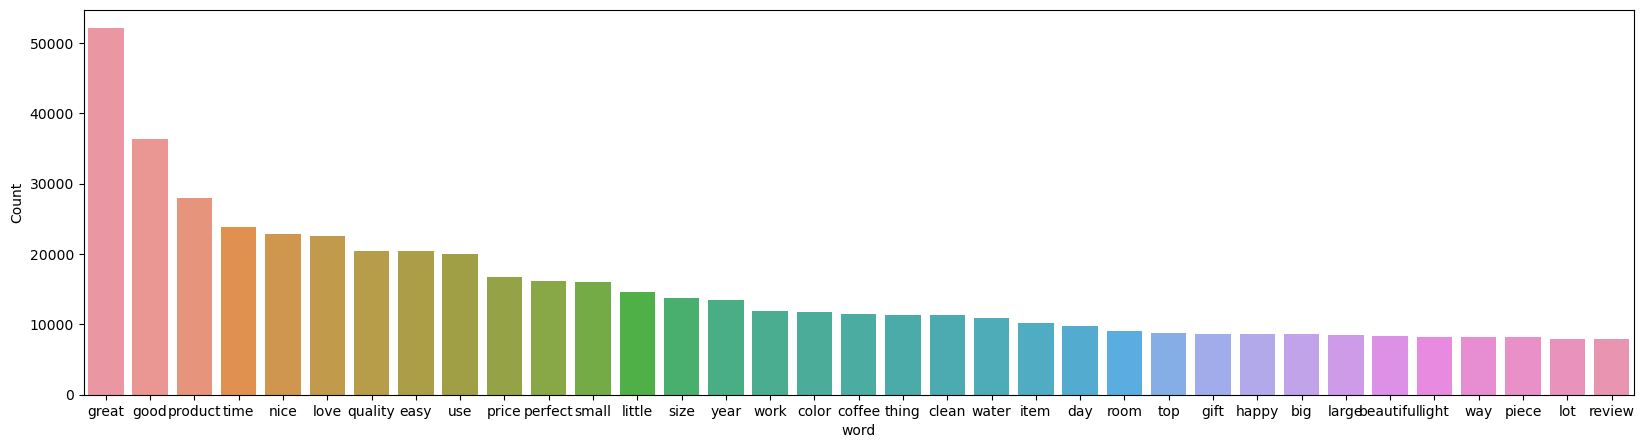

In [82]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

It seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.

## Building an LDA model

We will start by creating the term dictionary of our corpus, where every unique term is assigned an index

In [83]:
dictionary = corpora.Dictionary(reviews_2)

Convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above

In [84]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

# Creating the object for LDA model using gensim library
LDA = models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

In [85]:
lda_model.print_topics()

[(0,
  '0.100*"easy" + 0.076*"use" + 0.039*"clean" + 0.034*"great" + 0.018*"bright" + 0.018*"ice" + 0.017*"customer" + 0.014*"love" + 0.012*"time" + 0.012*"plate"'),
 (1,
  '0.027*"piece" + 0.017*"money" + 0.016*"frame" + 0.015*"item" + 0.015*"chair" + 0.013*"look" + 0.012*"box" + 0.012*"worth" + 0.012*"day" + 0.012*"time"'),
 (2,
  '0.121*"great" + 0.088*"quality" + 0.072*"good" + 0.058*"product" + 0.054*"love" + 0.048*"price" + 0.045*"beautiful" + 0.042*"gift" + 0.027*"cute" + 0.023*"nice"'),
 (3,
  '0.074*"nice" + 0.059*"picture" + 0.026*"heavy" + 0.023*"cheap" + 0.023*"light" + 0.022*"knife" + 0.021*"material" + 0.020*"good" + 0.018*"weight" + 0.017*"work"'),
 (4,
  '0.036*"cup" + 0.035*"water" + 0.027*"glass" + 0.026*"coffee" + 0.022*"hot" + 0.018*"lid" + 0.015*"tea" + 0.013*"use" + 0.013*"cold" + 0.013*"good"'),
 (5,
  '0.134*"color" + 0.040*"table" + 0.036*"bottle" + 0.029*"photo" + 0.027*"awesome" + 0.023*"nice" + 0.022*"love" + 0.018*"blue" + 0.018*"fun" + 0.018*"delivery"'),


Topic 1 has words like 'frame', 'chair', 'box' which indicates that the topic is related to furniture.
Topic 4 has words like 'cup', 'water', 'glass', 'coffee', 'tea' which related the topic to beverages-related objects.
Words like 'bed', 'rug', 'fabric', 'comfortable', 'mattress', etc. are good indicators of topic 7 being strongly related to bedroom-related items.

In [147]:
# Retrieve reviews from a specific topic
topic_id = 7  # topic ID of interest
reviews = []
cnt = 0
for i, doc in enumerate(doc_term_matrix):
    topic_probs = lda_model.get_document_topics(doc)
    for t_id, prob in topic_probs:
        if t_id == topic_id:
            if prob > 0.5:  # filter reviews with high topic probability
                reviews.append(df['reviewText'][i])
                cnt += 1
    if cnt == 5:
        break
reviews

['Great vacuum wife loves',
 'off button broke use First wouldnt stay but was able get stuck the position can still use plugging and unplugging Glad got the warranty Now have submit claim Other than that purchased this get control the cat hair new hardwood floors bedroom The strong suction perfect for that keeps floor really clean The compact streamlined head and long reach allows get all the way under bed reach all the fur balls used the handheld brush clean duvet cover cat hair and worked incredibly well Before would use roller tape brushes remove the hair but this cut that time down from hour minutes clean king size duvet front and back and don have the tape mess clean don recommend this for carpet doesn well Dyson but works better than Dyson hard floors',
 'This handy little vacuum like the fact light weight does well bare floors and rugs but think you need something little stronger for full house carpet',
 'Extra battery pack the best thing about this product One charge only last 

## Topics Visualization

In [87]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/dikshachand/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.178293  0.090310       1        1  16.453886
1     -0.172300  0.059462       2        1  12.230802
4     -0.148172  0.028636       3        1  11.988961
6      0.116008  0.034789       4        1  11.093762
2      0.195538  0.209440       5        1  10.509399
8     -0.148102 -0.159359       6        1   9.809161
0      0.021730  0.215538       7        1   8.102414
3      0.014119 -0.081698       8        1   7.555303
7     -0.034934 -0.247110       9        1   7.192461
5      0.334405 -0.150008      10        1   5.063850, topic_info=          Term          Freq         Total Category  logprob  loglift
25       great  46900.000000  46900.000000  Default  30.0000  30.0000
170    quality  22088.000000  22088.000000  Default  29.0000  29.0000
109       easy  19372.000000  19372.000000  Default  28.0000  28.0000
750      color  16152.000000  16152.000000  Default  27.0000  27.0000
20       small  17716.000000  17716.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
40        love   2718.987935  24591.476483  Topic10  -3.7951   0.7809
94     perfect   2017.626931  18350.920472  Topic10  -4.0934   0.7753
552  different   1315.484649   5260.838391  Topic10  -4.5212   1.5970
366       room   1310.323435   9525.238998  Topic10  -4.5251   0.9994
634       soft   1221.608902   8126.925273  Topic10  -4.5952   1.0880

[505 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
357       1  0.999072    accurate
657       4  0.999258    addition
631      10  0.999415    adorable
1030      7  0.997938  advertised
1478      5  0.997044  affordable
...     ...       ...         ...
584       7  0.105292       worth
4577      5  0.998025     wrinkle
157       1  0.999909        year
754       6  0.998512      yellow
5827      6  0.999163      zipper

[666 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 5, 7, 3, 9, 1, 4, 8, 6])

In [88]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5463271998280584


# Alternative models

## Model 2

To capture even finer details in the data and to get more descriptive results than Model 1, I will increase the number of topics from 10 to 20, keeping other parameters constant.

In [89]:
# Build alternative LDA model with different number of topics
lda_model2 = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, random_state=100,
                chunksize=1000, passes=50)

In [90]:
lda_model2.print_topics()

[(0,
  '0.291*"love" + 0.092*"cute" + 0.055*"daughter" + 0.029*"kid" + 0.028*"bright" + 0.027*"ice" + 0.026*"fun" + 0.019*"wonderful" + 0.019*"birthday" + 0.018*"pretty"'),
 (1,
  '0.063*"year" + 0.038*"time" + 0.038*"month" + 0.036*"new" + 0.036*"old" + 0.035*"money" + 0.035*"day" + 0.030*"one" + 0.029*"week" + 0.026*"first"'),
 (2,
  '0.072*"amazing" + 0.047*"hard" + 0.046*"holder" + 0.044*"deal" + 0.042*"sharp" + 0.036*"blade" + 0.033*"detail" + 0.029*"end" + 0.028*"issue" + 0.023*"hope"'),
 (3,
  '0.090*"kitchen" + 0.076*"knife" + 0.055*"cool" + 0.054*"inch" + 0.051*"clock" + 0.050*"print" + 0.045*"pleased" + 0.033*"wife" + 0.027*"spoon" + 0.023*"collection"'),
 (4,
  '0.104*"cup" + 0.101*"water" + 0.075*"coffee" + 0.044*"hot" + 0.043*"tea" + 0.028*"cold" + 0.024*"machine" + 0.024*"drink" + 0.024*"filter" + 0.019*"basket"'),
 (5,
  '0.240*"gift" + 0.140*"soft" + 0.105*"sheet" + 0.067*"friend" + 0.036*"adorable" + 0.031*"wedding" + 0.029*"video" + 0.024*"silicone" + 0.023*"cookie" +

Here, the topics seem much more specific and descriptive than the first model. For example, we can identify that topic 15 is strongly related to food containers and is telling of their ability to maintain temperature of food.

In [150]:
# Retrieve reviews from a specific topic
topic_id = 15  # topic ID of interest
reviews = []
cnt = 0
for i, doc in enumerate(doc_term_matrix):
    topic_probs = lda_model2.get_document_topics(doc)
    for t_id, prob in topic_probs:
        if t_id == topic_id:
            if prob > 0.5:  # filter reviews with high topic probability
                reviews.append(df['reviewText'][i])
                cnt += 1
    if cnt == 5:
        break
reviews

['Awesome containers for condiments',
 'second pressure cooker use them quite bit',
 'use these pressure cookers make home center for our chocolates that dip afterwards This tradition that dear MOM started and the family doing the same',
 'this pressure cooker seems great quality and husband loves cooking with too would recommend',
 'chose this pressure cooker because the only kind pressure cooker had experience using stainless steel non reactive heavy weight was less expensive than more modern incarnations pressure cookers electric countertop stove non jiggle top and the reviews and follow comments were helpful convincing that this was quality product The reviews praise the quality construction this cooker and couldn agree more have used both natural pressure release and the method speed sticking the cooker the sink and running cold water from the faucet over takes all seconds and doesn have complicated making ice bath for the sink have never seen any signs the metal layers splitting 

In [91]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model2, doc_term_matrix, dictionary)
vis

/Users/dikshachand/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.166605 -0.186556       1        1  9.404348
19    -0.184666 -0.018345       2        1  9.166958
15    -0.203351 -0.067964       3        1  7.006320
11     0.231728 -0.268968       4        1  6.144985
9     -0.086978 -0.018701       5        1  5.610248
13    -0.166334 -0.056812       6        1  5.406936
8     -0.079360  0.134364       7        1  5.343536
14     0.010123 -0.235718       8        1  5.211102
16    -0.038956  0.096135       9        1  5.039176
4     -0.122536  0.020075      10        1  4.980369
18     0.246387 -0.169441      11        1  4.714767
7     -0.152152  0.035689      12        1  4.586887
17     0.064030  0.101962      13        1  4.401461
12     0.027412  0.053417      14        1  4.259777
0      0.089267  0.055040      15        1  3.860691
10     0.069659  0.096960      16        1  3.648219
3      0.118065  0.132326      17        1  3.007379
6      0.099528  0.057484      18        1  2.948369
2      0.098796  0.137832      19        1  2.688429
5      0.145941  0.101221      20        1  2.570040, topic_info=          Term          Freq         Total Category  logprob  loglift
25       great  55648.000000  55648.000000  Default  30.0000  30.0000
0         good  37255.000000  37255.000000  Default  29.0000  29.0000
26        nice  30882.000000  30882.000000  Default  28.0000  28.0000
40        love  26800.000000  26800.000000  Default  27.0000  27.0000
94     perfect  24114.000000  24114.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1538    batter    208.441212    209.889123  Topic20  -5.6852   3.6543
1127      rack    841.192847   1144.594557  Topic20  -4.2901   3.3533
633       huge   1081.881048   2006.397144  Topic20  -4.0384   3.0436
1128      thin    473.176858   5664.856899  Topic20  -4.8654   1.1787
115   favorite    287.482482   2166.526797  Topic20  -5.3637   1.6415

[878 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
357       8  0.998170    accurate
657       4  0.999126    addition
726       6  0.997942  additional
631      20  0.999267    adorable
637       3  0.998383       adult
...     ...       ...         ...
354       2  0.191714       wrong
354       8  0.807129       wrong
157       1  0.999864        year
754       6  0.998653      yellow
1763     15  0.996420       young

[1134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 20, 16, 12, 10, 14, 9, 15, 17, 5, 19, 8, 18, 13, 1, 11, 4, 7, 3, 6])

This model naturally has more overlapping topics as the number of topics is increased. 

In [92]:
# Compute Coherence Score for second LDA model
coherence_model_lda = CoherenceModel(model=lda_model2, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.569217647638423


## Model 3

Few topics in the second model were largely overlapping. This reduces the interpretability of the model. In the next model, I will decrease the number of topics by 5. Additionally, I will use LdaMulticore to help decrease the processing time and experiment with changing the number of passes to 10.

In [93]:
lda_model3 = models.LdaMulticore(corpus=doc_term_matrix, num_topics=15, id2word=dictionary, passes=10, workers=4)

In [94]:
lda_model3.print_topics()

[(0,
  '0.032*"candle" + 0.031*"ice" + 0.017*"plate" + 0.017*"time" + 0.016*"egg" + 0.016*"food" + 0.016*"tray" + 0.014*"scent" + 0.012*"mold" + 0.010*"cook"'),
 (1,
  '0.055*"soft" + 0.055*"bed" + 0.046*"sheet" + 0.042*"nice" + 0.025*"mattress" + 0.022*"comfortable" + 0.020*"towel" + 0.020*"thin" + 0.017*"cover" + 0.015*"size"'),
 (2,
  '0.023*"lid" + 0.017*"container" + 0.015*"plastic" + 0.015*"handle" + 0.015*"large" + 0.015*"small" + 0.014*"bowl" + 0.014*"heavy" + 0.014*"dishwasher" + 0.014*"size"'),
 (3,
  '0.089*"gift" + 0.036*"great" + 0.029*"friend" + 0.029*"awesome" + 0.027*"rug" + 0.026*"daughter" + 0.024*"vacuum" + 0.017*"floor" + 0.014*"dog" + 0.014*"party"'),
 (4,
  '0.192*"great" + 0.107*"good" + 0.105*"quality" + 0.083*"product" + 0.068*"price" + 0.026*"excellent" + 0.024*"nice" + 0.019*"happy" + 0.017*"purchase" + 0.014*"thank"'),
 (5,
  '0.181*"love" + 0.080*"perfect" + 0.056*"small" + 0.054*"size" + 0.041*"cute" + 0.033*"glass" + 0.033*"light" + 0.022*"clock" + 0.021*

Here, I changed the model to LDAMulticore which increased the performance on the model and decreased preprocessing time.
Even in this case, the models are depictive of the subject they cover - like Topic 10 representing kitchen appliances, topic 13 covering heating/cooling appliances.

In [152]:
# Retrieve reviews from a specific topic
topic_id = 10  # topic ID of interest
reviews = []
cnt = 0
for i, doc in enumerate(doc_term_matrix):
    topic_probs = lda_model3.get_document_topics(doc)
    for t_id, prob in topic_probs:
        if t_id == topic_id:
            if prob > 0.5:  # filter reviews with high topic probability
                reviews.append(df['reviewText'][i])
                cnt += 1
    if cnt == 5:
        break
reviews

['Fine for small jobs',
 'Works wells floors Uncomfortable grip',
 'Best peeler ive ever owned',
 'Always the best peeler',
 'Solid feeling Nice grip and good angle this large wheel pizza cutter']

In [95]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, doc_term_matrix, dictionary)
vis

/Users/dikshachand/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.081703 -0.125286       1        1  12.394779
7     -0.012807  0.132733       2        1  10.660250
2      0.043666  0.138834       3        1   7.790213
11     0.169995  0.022582       4        1   7.588319
4     -0.165043 -0.251984       5        1   7.232486
13     0.105822  0.010240       6        1   7.060954
14     0.104985 -0.149269       7        1   7.047075
6      0.159584  0.000985       8        1   6.159672
1     -0.083555  0.098558       9        1   5.625757
8     -0.284815  0.058156      10        1   5.483768
5     -0.196470  0.131633      11        1   5.089310
0      0.134760 -0.021919      12        1   5.008754
3     -0.114605 -0.219886      13        1   4.876341
12     0.072804  0.068555      14        1   4.332347
10    -0.016024  0.106067      15        1   3.649974, topic_info=        Term          Freq         Total Category  logprob  loglift
25     great  49796.000000  49796.000000  Default  30.0000  30.0000
40      love  22151.000000  22151.000000  Default  29.0000  29.0000
170  quality  20986.000000  20986.000000  Default  28.0000  28.0000
41   product  26482.000000  26482.000000  Default  27.0000  27.0000
109     easy  20845.000000  20845.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
822   handle    721.969279   3996.907716  Topic15  -4.7937   1.5992
26      nice   1065.714802  24084.966104  Topic15  -4.4043   0.1925
75       use    763.514422  21227.341466  Topic15  -4.7378  -0.0147
33    little    693.882938  14946.989958  Topic15  -4.8334   0.2405
46       bit    469.261544   7029.557711  Topic15  -5.2245   0.6037

[933 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4849     11  0.988203        aaa
6779      5  0.995453  absorbent
4902     10  0.996385     accent
357       1  0.115241   accurate
357      11  0.657549   accurate
...     ...       ...        ...
1570      2  0.055178        zip
1570     14  0.943040        zip
5827      9  0.115616     zipper
5827     14  0.883634     zipper
3823      4  0.996056   zucchini

[2353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 3, 12, 5, 14, 15, 7, 2, 9, 6, 1, 4, 13, 11])

In [96]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model3, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.627039118246413


We achieved the highest coherence score for this model, with producing pretty useful clusters. Also, even though the number of passes is reduced, we see better convergence of data.

In [104]:
# Saving the best LDA model
import pickle
pickle.dump(lda_model3, open('/Users/dikshachand/Documents/Applied ML/HW3/topic.model', 'wb'))